In [120]:
import pandas as pd

In [121]:
data = pd.read_csv('../Data/epsPQRS.csv', sep=';')
data

,Comentario,Area
0,pqrd-18-0674823nurc 1-2018-221502entidad: capi...,Otro
1,pqrd-18-0675272nurc 1-2018-216612entidad: capi...,Oportunidad Citas Red Contratada
2,pqrd-18-0675410nurc 1-2018-221583entidad: capi...,Dificultad Accesibilidad Administrativa
3,pqrd-18-0675530nurc 1-2018-217812entidad: capi...,Otro
4,favor enviar copia al ministerio de salud y pr...,Otro
...,...,...
82773,apixaban 5 mg tableta,No Suministro Medicamentos
82774,ss solucion mipres 20201123175024488426,Negación De ServiciosDificultad MédicoAdmin
82775,ss implante de dispositivo en cornea asistido,Negación De ServiciosDificultad MédicoAdmin
82776,ss control hepatologia ips fundacion santa fe,Negación De ServiciosDificultad MédicoAdmin


In [122]:
data = data.sample(frac=0.7)

In [123]:
data.Area.value_counts(normalize=True)

Oportunidad Citas Red Contratada                  0.430598
No Suministro Medicamentos                        0.171904
Dificultad Accesibilidad Administrativa           0.119717
Otro                                              0.094055
Inconsistencias Sistemas De InformacionAsegura    0.071551
Solicitudes Web                                   0.060230
Negación De ServiciosDificultad MédicoAdmin       0.051946
Name: Area, dtype: float64

In [124]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

In [125]:
print(f'Tenemos {data.shape[0]} datos en total.')
print(f'El conjunto de entrenamiento (train) tiene {train.shape[0]} datos.')
print(f'El conjunto de prueba (test) tiene {test.shape[0]} datos.')

Tenemos 57945 datos en total.
El conjunto de entrenamiento (train) tiene 46356 datos.
El conjunto de prueba (test) tiene 11589 datos.


In [126]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
#stopwords_sp = stopwords.words('spanish')

In [127]:
stopwords_sp.extend(["pqrd", "entidad", "nurc", "dia", "capital", "salud","bogotá"])
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [128]:
X_train = tfidf_vect.fit_transform(train.Comentario.values)
y_train = train.Area.values

In [129]:
X_test = tfidf_vect.transform(test.Comentario.values)
y_test = test.Area.values

In [130]:
print(f"Tamaño de X_train (entrenamiento): {pd.DataFrame(X_train.toarray()).shape}")
print(f"Tamaño de X_test (prueba): {pd.DataFrame(X_test.toarray()).shape}")
print(f"Tamaño de y_train {len(y_train)} y tamaño de y_test {len(y_test)}")

Tamaño de X_train (entrenamiento): (46356, 46726)
Tamaño de X_test (prueba): (11589, 46726)
Tamaño de y_train 46356 y tamaño de y_test 11589


# Modelos

In [131]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [132]:
solicitud = ['diagnóstico posible derrame interno se encuentra hospitalizado en la ips hospital de san jorge',
             'Tengo mucho dolor de cabeza y necesito atencion', 
             'Estoy solicitando una cita desde hace mucho tiempo']
solicitud_trans = tfidf_vect.transform(solicitud)

# Naive Bayes

In [133]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [134]:
nb.fit(X_train, y_train)

MultinomialNB()

In [135]:
y_pred_nb = nb.predict(X_test)

In [136]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_nb):>15.2f}')

Exactitud:            0.65


In [137]:
print(classification_report(y_test, y_pred_nb))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.61      0.27      0.38      1360
Inconsistencias Sistemas De InformacionAsegura       0.95      0.33      0.49       829
   Negación De ServiciosDificultad MédicoAdmin       0.74      0.04      0.07       599
                    No Suministro Medicamentos       0.73      0.60      0.66      1993
              Oportunidad Citas Red Contratada       0.59      0.97      0.74      5015
                                          Otro       0.73      0.08      0.14      1091
                               Solicitudes Web       1.00      1.00      1.00       702

                                      accuracy                           0.65     11589
                                     macro avg       0.77      0.47      0.50     11589
                                  weighted avg       0.69      0.65      0.59     11589



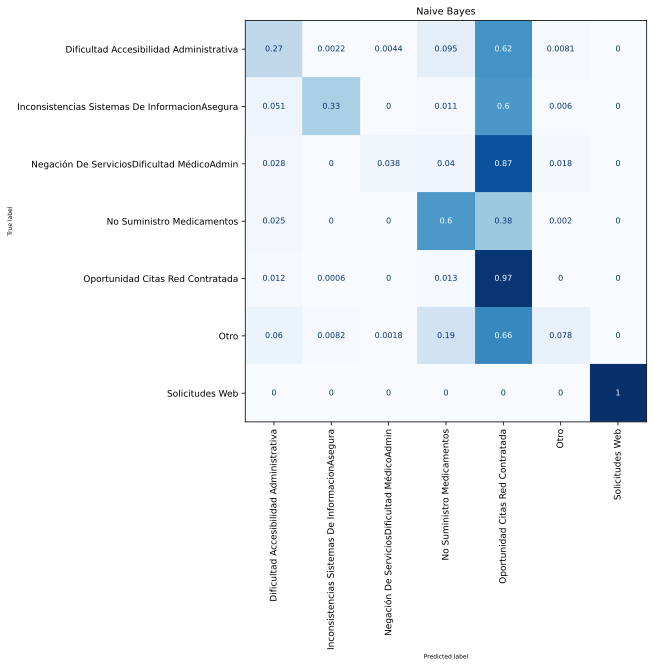

In [138]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (9, 9))

# Set general font size
plt.rcParams['font.size'] = '8'

plot_confusion_matrix(nb, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Naive Bayes")
plt.show()

In [139]:
print(nb.predict(solicitud_trans))

['Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada'
 'Oportunidad Citas Red Contratada']


# Regresión Logística

In [140]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')

In [141]:
logreg.fit(X_train, y_train)

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [142]:
y_pred_logreg = logreg.predict(X_test)

In [143]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_logreg):>15.2f}')

Exactitud:            0.73


In [144]:
print(classification_report(y_test, y_pred_logreg))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.50      0.51      0.50      1360
Inconsistencias Sistemas De InformacionAsegura       0.73      0.83      0.78       829
   Negación De ServiciosDificultad MédicoAdmin       0.38      0.55      0.45       599
                    No Suministro Medicamentos       0.73      0.73      0.73      1993
              Oportunidad Citas Red Contratada       0.92      0.80      0.86      5015
                                          Otro       0.40      0.48      0.43      1091
                               Solicitudes Web       1.00      1.00      1.00       702

                                      accuracy                           0.73     11589
                                     macro avg       0.67      0.70      0.68     11589
                                  weighted avg       0.75      0.73      0.74     11589



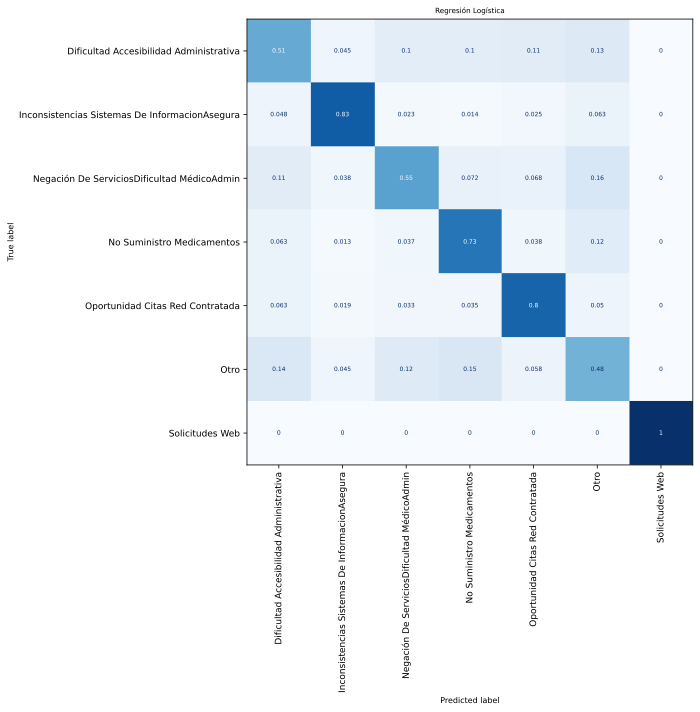

In [145]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(logreg, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Regresión Logística")
plt.show()

In [146]:
print(logreg.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Dificultad Accesibilidad Administrativa'
 'Oportunidad Citas Red Contratada']


# Árbol de decisión

In [147]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced')

In [148]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [149]:
y_pred_dt = dt.predict(X_test)

In [150]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_dt):>15.2f}')

Exactitud:            0.66


In [151]:
print(classification_report(y_test, y_pred_dt))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.45      0.48      0.46      1360
Inconsistencias Sistemas De InformacionAsegura       0.68      0.65      0.66       829
   Negación De ServiciosDificultad MédicoAdmin       0.31      0.37      0.34       599
                    No Suministro Medicamentos       0.63      0.63      0.63      1993
              Oportunidad Citas Red Contratada       0.83      0.76      0.79      5015
                                          Otro       0.32      0.38      0.35      1091
                               Solicitudes Web       1.00      1.00      1.00       702

                                      accuracy                           0.66     11589
                                     macro avg       0.60      0.61      0.60     11589
                                  weighted avg       0.67      0.66      0.66     11589



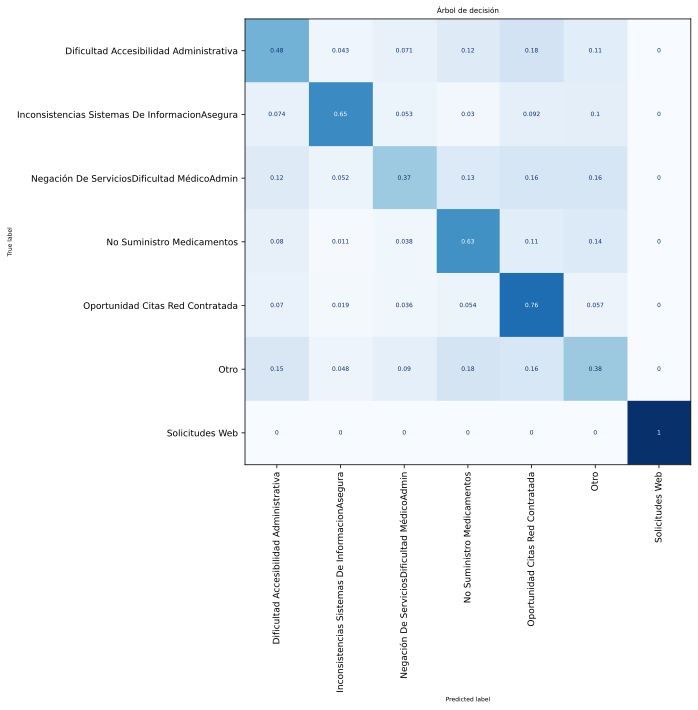

In [152]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(dt, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Árbol de decisión")
plt.show()

In [153]:
print(dt.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada']


# Red Neuronal

In [158]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, activation='logistic', max_iter=100,hidden_layer_sizes=(20,30), random_state=1)

In [159]:
clf.fit(X_train, y_train)

C:\Users\Jojstepersan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 30, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [160]:
y_pred_clf = clf.predict(X_test)

In [161]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_clf):>15.2f}')

Exactitud:            0.59


In [162]:
print(classification_report(y_test, y_pred_clf))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.46      0.39      0.42      3008
                            Dificultad Tutelas       0.15      0.19      0.16       673
Inconsistencias Sistemas De InformacionAsegura       0.64      0.48      0.55      1961
          Incumplimiento Portabilidad Nacional       0.13      0.10      0.11       258
                         Negación De Servicios       0.21      0.26      0.23       635
   Negación De ServiciosDificultad MédicoAdmin       0.25      0.30      0.27      1395
                    No Suministro Medicamentos       0.58      0.54      0.56      4542
              Oportunidad Citas Red Contratada       0.73      0.78      0.75     11003

                                      accuracy                           0.59     23475
                                     macro avg       0.39      0.38      0.38     23475
                              

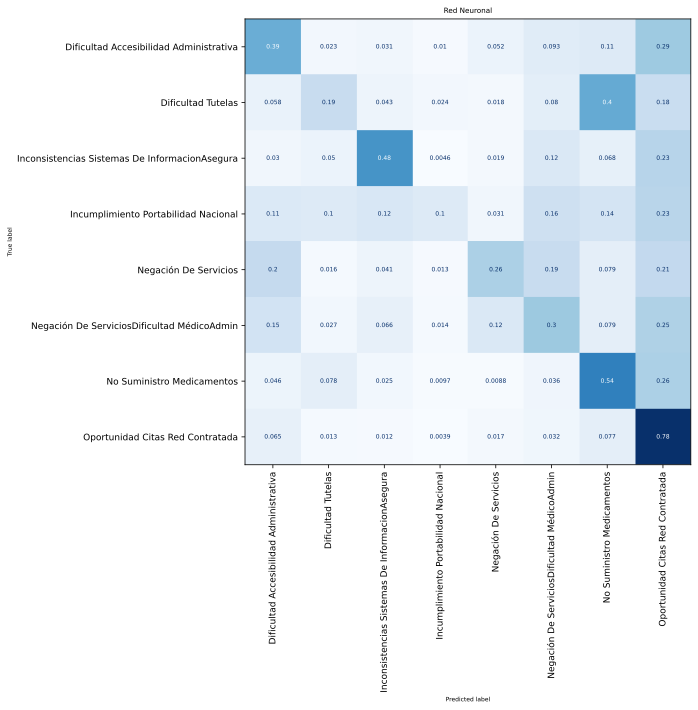

In [163]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(clf, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Red Neuronal")
plt.show()

In [164]:
clf.predict(solicitud_trans)

array(['Negación De Servicios', 'Dificultad Accesibilidad Administrativa',
       'Oportunidad Citas Red Contratada'], dtype='<U46')

# SVM

In [154]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced')

In [155]:
svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [156]:
y_pred_svm = svm.predict(X_test)

In [157]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_svm):>15.2f}')

Exactitud:            0.74


In [158]:
print(classification_report(y_test, y_pred_svm))

                                                precision    recall  f1-score   support

       Dificultad Accesibilidad Administrativa       0.52      0.49      0.50      1360
Inconsistencias Sistemas De InformacionAsegura       0.78      0.80      0.79       829
   Negación De ServiciosDificultad MédicoAdmin       0.42      0.46      0.44       599
                    No Suministro Medicamentos       0.72      0.75      0.74      1993
              Oportunidad Citas Red Contratada       0.88      0.85      0.87      5015
                                          Otro       0.42      0.46      0.44      1091
                               Solicitudes Web       1.00      1.00      1.00       702

                                      accuracy                           0.74     11589
                                     macro avg       0.68      0.69      0.68     11589
                                  weighted avg       0.74      0.74      0.74     11589



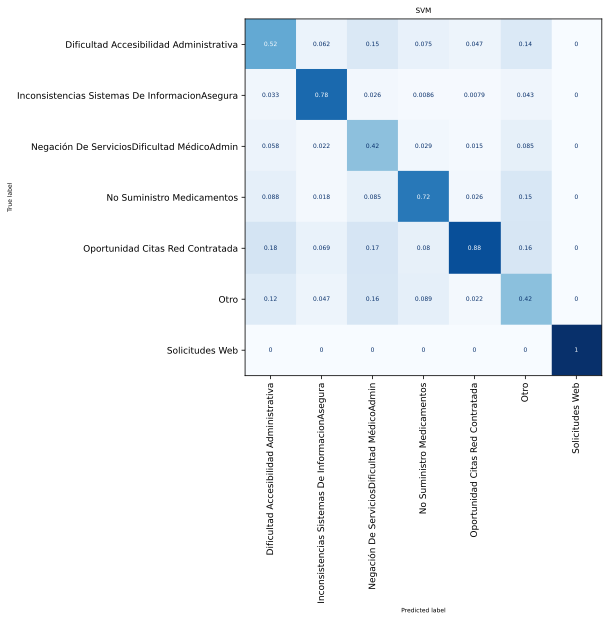

In [162]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (8, 8))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(svm, X_test, y_test, cmap="Blues", ax=ax, normalize='pred').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("SVM")
plt.show()

In [161]:
print(svm.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Dificultad Accesibilidad Administrativa'
 'Oportunidad Citas Red Contratada']
